[시계열수치입력 수치예측 모델](https://tykimos.github.io/2017/09/09/Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe/)<br>
[Scikit_learn의 전처리기능-스케일링-](https://datascienceschool.net/view-notebook/f43be7d6515b48c0beb909826993c856/)  
아래 내용은 상위 링크를 정리한것.

# 시계열수치입력 수치예측 모델

각 모델에 cosine(코사인)데이터를 학습 시킨 후, <br>
처음 일부 데이터를 알려주면 이후 코사인 형태의 데이터 예측을 얼마나 잘 하는지 테스트한다.<br>

## 데이터셋 준비

시간의 흐름에 따라 진폭이 -1.0에서 1.0사이로 변하는 1,600개의 실수값을 생성한다.

In [9]:
import numpy as np

signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

생성된 데이터를 확인해본다.

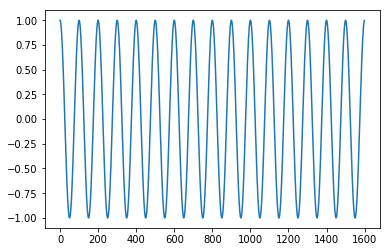

In [12]:
import matplotlib.pyplot as plt

plot_x = np.arange(1600)
plot_y = signal_data
plt.plot(plot_x, plot_y)
plt.show()

생성한 코사인 데이터를 모델에 학습시키기 위해서는 데이터와 라벨로 구성된 데이터셋으로 만들어야 한다.<br>
* **이전 수치들은**<br>
입력하여 다음 수치를 예측하는 문제이므로 데이터는 이전 수치들이 되고,<br>
* **라벨은**<br>
다음 수치가 된다.

다른예제들과는 달리 데이터와 라벨이 모두 같은 속성이다.<br>
아래 crate_dataset() 메소드는 시계열 수치를 입력받아 데이터 셋을 생성한다.<br>
이 때 <br>
* **look_back 인자는** <br>
얼마만큼의 이전 수치를 데이터로 만들 것인가를 결정한다.<br>

In [13]:
signal_data

array([[1.        ],
       [0.99802673],
       [0.9921147 ],
       ...,
       [0.98228725],
       [0.9921147 ],
       [0.99802673]])

In [34]:
def create_dataset(signal_data, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i : (i + look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

-1.0에서 1.0까지의 값을 가지는 코사인 데이터를 0.0과 1.0 사이의 값을 가지도록 정규화를 한 뒤 훈련셋과 시험셋으로 분리한다.(Scalering과정)  
이전 20개의 수치를 입력하여 다음 수치 1개를 예측하는 데이터셋을 만들기 위해 look_back인자를 40으로 설정한다.  
**look_back 인자에 따라 모델의 성능이 달라지므로 적정 값을 지정하는 것이 중요하다.**  
그러나 look_back 인자가 어떻게 성능을 결정하는지에 대한 의문이 아직 있다.  
자세한 내용은 추가하도록 한다.

In [35]:
from sklearn.preprocessing import MinMaxScaler

look_back = 40

#데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
singnal_data = scaler.fit_transform(signal_data)

#데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

#데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
c_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

## 레이어 준비

|블록|이름|설명|
|---|---|---|
|![LSTM](http://tykimos.github.io/warehouse/DeepBrick/Model_Recipe_Part_LSTM_s.png)|LSTM|Long-Short Term Memory unit의 약자로 순환 신경망 레이어중 하나이다.|
|![than](http://tykimos.github.io/warehouse/DeepBrick/Model_Recipe_Part_Activation_tanh_s.png)|tanh|LSTM의 출력 활성화 함수로 사용된다.|

아래 그림은 4개의 타임스텝을 가진 LSTM을 표시한것이다.  
출력 활성화 함수로 tanh를 사용하였다.  
그림에는 타임스텝에 따라 별로의 블록으로 형상화하나, 내부적으로 모든 블록은 같은 가중치를 사용한다.  
![LSTM-image](http://tykimos.github.io/warehouse/DeepBrick/Model_Recipe_Part_LSTM_Example_m.png)

## 모델 준비
시계열수치를 입력하여 수치를 예측하기 위해 **다층퍼셉트론 모델**, **순환신경망 모델**, **상태유지 순환신경망 모델**, **상태유지 스택 순환신경망 모델**을 사용한다.  

### 다층퍼셉트론 모델

Dense 레이어가 4개인 다층퍼셉트론 모델이다.  
은닉층에서 사용된 Dense레이어는 32개의 뉴런을 가지고 있고, **ReLU**활성화 함수를 사용한다.  
출력층의 Dense 레이어는 하나의 수치값을 예측하기 위해서 1개의 뉴런을 가지며,  
별도의 활성화 함수를 사용하지 않았다.  
과적합을 방지하기 위해 Dropout레이어가 삽입된다.  

![다층퍼셉트론 모델](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_1m.png)

### 순환신경망 모델
한 개의 LSTM 레이어를 이용하여 순환신경망 모델을 구성한 그림이다.  
출력층은 하나의 수치값을 예측하기 위해 1개 뉴런을 가진  Dense 레이어를 사용한다.

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(None, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))

![](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_2m.png)

### 상태유지 순환신경망 모델
순환신경망 모델과 동일하나 'stateful = True'옵션을 사용하여 상태유지 가능한 순환신경망 모델을 구성하였다.  
상태유지 모드일 경우 한 배치에서 학습된 상태가 다음 배치 학습 시에 전달되는 방식이다.
```python
model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
```
![](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_3m.png)

### 상태유지 스택 순환신경망 모델
상태유지 순환신경망을 여러겹 쌓아올린 모델이다.  
층이 하나인 순환신경망에 비해 더 깊은 추론이 가능한 모델이다.  
```python
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
```
![](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_4m.png)

## 전체 소스
### 다층퍼셉트론 모델

Train on 760 samples, validate on 360 samples
Epoch 1/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0899 - val_loss: 0.0427
Epoch 2/200
760/760 [==============================] - 0s 139us/step - loss: 0.0484 - val_loss: 0.0244
Epoch 3/200
760/760 [==============================] - 0s 133us/step - loss: 0.0416 - val_loss: 0.0191
Epoch 4/200
760/760 [==============================] - 0s 138us/step - loss: 0.0333 - val_loss: 0.0298
Epoch 5/200
760/760 [==============================] - 0s 137us/step - loss: 0.0296 - val_loss: 0.0176
Epoch 6/200
760/760 [==============================] - 0s 133us/step - loss: 0.0272 - val_loss: 0.0277
Epoch 7/200
760/760 [==============================] - 0s 131us/step - loss: 0.0322 - val_loss: 0.0196
Epoch 8/200
760/760 [==============================] - 0s 132us/step - loss: 0.0299 - val_loss: 0.0217
Epoch 9/200
760/760 [==============================] - 0s 132us/step - loss: 0.0249 - val_loss: 0.0213
Epoch 10/200
760/760 [=======

760/760 [==============================] - 0s 130us/step - loss: 0.0110 - val_loss: 0.0207
Epoch 158/200
760/760 [==============================] - 0s 128us/step - loss: 0.0097 - val_loss: 0.0218
Epoch 159/200
760/760 [==============================] - 0s 128us/step - loss: 0.0108 - val_loss: 0.0219
Epoch 160/200
760/760 [==============================] - 0s 129us/step - loss: 0.0093 - val_loss: 0.0208
Epoch 161/200
760/760 [==============================] - 0s 128us/step - loss: 0.0123 - val_loss: 0.0200
Epoch 162/200
760/760 [==============================] - 0s 133us/step - loss: 0.0098 - val_loss: 0.0212
Epoch 163/200
760/760 [==============================] - 0s 125us/step - loss: 0.0096 - val_loss: 0.0197
Epoch 164/200
760/760 [==============================] - 0s 129us/step - loss: 0.0096 - val_loss: 0.0192
Epoch 165/200
760/760 [==============================] - 0s 128us/step - loss: 0.0110 - val_loss: 0.0197
Epoch 166/200
760/760 [==============================] - 0s 129us/ste

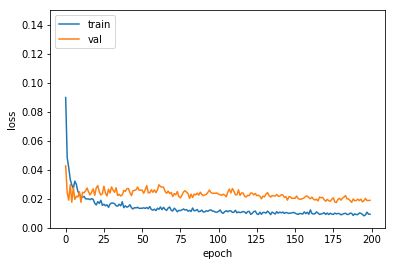

Train Score:  0.019253243922599052
Validation Score:  0.018945263905657664
Test Score :  0.019253243922599052


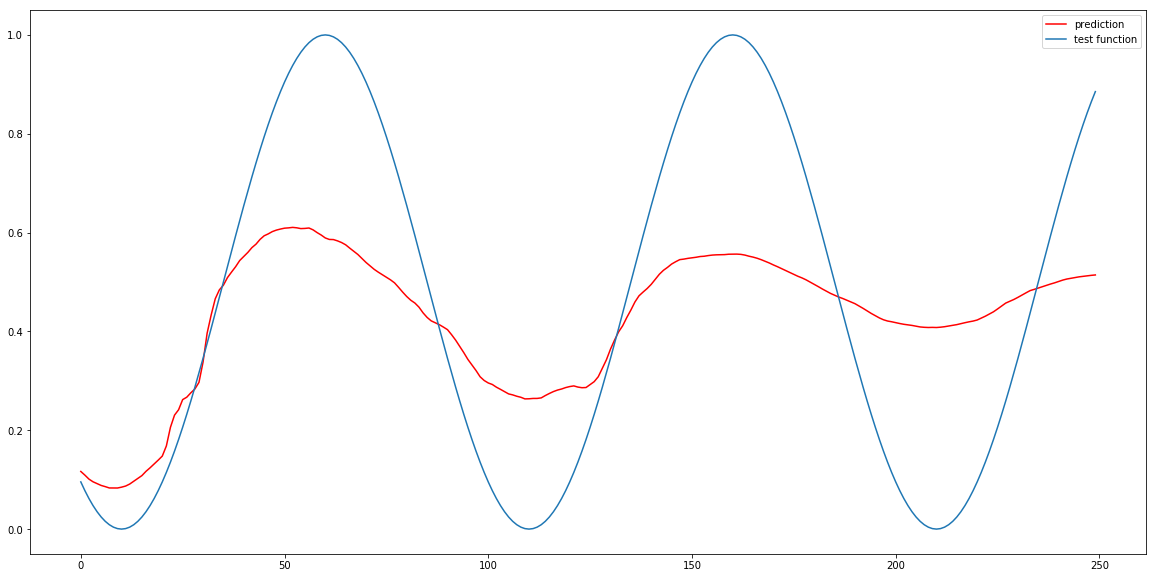

In [3]:
# 사용할 패키지 로드
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0]) ## [i:(i+look_back), 0] x row 값을 지정하는 append.
                                                      ## look_back이 클수록 x값도 커진다.
        dataY.append(signal_data[i + look_back, 0]) ## [i + look_back, 0] 지정된 x값을 제외한 한개의 y row값
    return np.array(dataX), np.array(dataY)

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600) * (20 * np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1)) ## 0~1까지 Nomeralize
signal_data = scaler.fit_transform(signal_data) ## signal_data를 Nomeralize 변수에 적용

# 데이터 분리
train = signal_data[0:800] ## 0에서 799번째 위치 까지의 데이터를 train 데이터로 생성
val = signal_data[800:1200] ## 800번째 부터 1190번 위치까지의 데이터를 val데이터로 생성
test = signal_data[1200:] ## 1200부터 마지막위치까지 데이터를 test데이터로 생성

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리 ## 다시 이해 해보기
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_train = np.squeeze(x_train)
x_val = np.squeeze(x_val)
x_test = np.squeeze(x_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(32, input_dim=40, activation="relu"))
model.add(Dropout(0.3))
for i in range(2):
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adagrad') ## mean squared error 다시 공부하기

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15) ##???????
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
print('Validation Score: ', valScore)
testScore = model.evaluate(x_train, y_train, verbose=0)
print('Test Score : ', testScore)

# 7. 모델 사용하기
look_ahead = 250 # 왜 250 주나?
 
xhat = x_test[0, None]
predictions = np.zeros((look_ahead, 1))
for i in range(look_ahead):
    prediction = model.predict(xhat, batch_size=32)
    predictions[i] = prediction
    xhat = np.hstack([xhat[:, 1:], prediction])
    
plt.figure(figsize=(20, 10))
plt.plot(np.arange(look_ahead), predictions, 'r', label='prediction')
plt.plot(np.arange(look_ahead), y_test[:look_ahead], label="test function") ## y_test가 이해되지 않음
plt.legend()
plt.show()